In [94]:
import requests
from dotenv import load_dotenv
import yfinance as yf
import plotly.express as px
import pandas as pd
import numpy as np
import panel as pn
# from panel.interact import interact
import matplotlib.pyplot as plt
from pathlib import Path
import pylab as plt
import plotly.graph_objects as go
from dotenv import load_dotenv

%matplotlib inline
pn.extension('plotly') 
import hvplot.pandas
from pandas import DataFrame

import seaborn as sns
import scipy.optimize as sco


In [95]:
load_dotenv()

True

In [96]:
ticker_list = ['VOO', 'QQQ', 'XLE', 'IWM', 'DJI', 'XLF', 'DXY', 'DJT', 'GSG', 'AGG', 'GLD', 'BTC-USD']

In [97]:
def tickerListGrab(ticker_list, period="5y"):
    df_price = pd.DataFrame()
    df_return = pd.DataFrame()
   
    for ticker in ticker_list:
        out = [0]
        symbol = yf.Ticker(ticker)
        symbol_list = symbol.history(period=period)
        symbol_list = symbol_list.drop(["Dividends","Stock Splits"],axis = 1)
        symbol_list = symbol_list.dropna()
        symbol_list = symbol_list.sort_index(ascending=True)
        for i in range(len(symbol_list)-1):
            out.append((symbol_list['Close'][i+1]-symbol_list['Close'][i])/symbol_list['Close'][i])
        symbol_list['Return'] = out
        df_price = pd.concat([df_price,symbol_list['Close']],axis=1)
        df_return = pd.concat([df_return,symbol_list['Return']],axis=1)
        df_price = df_price.rename(columns={'Close':ticker})
        df_return = df_return.rename(columns={'Return':ticker+'_Return'})
 
    df_price = df_price.dropna()
    df_return = df_return.dropna()
    return df_price,df_return

In [98]:
df_price,df_return = tickerListGrab(ticker_list)
df_price

,VOO,QQQ,XLE,IWM,DJI,XLF,DXY,DJT,GSG,AGG,GLD,BTC-USD
2017-01-17,189.721970,118.427086,58.996784,126.298935,19826.800781,20.803051,1061.180054,9099.580078,15.62,96.531487,115.849998,907.937988
2017-01-18,190.123825,118.668198,58.862789,126.712387,19804.699219,20.975277,1055.280029,9140.879883,15.41,96.114433,114.870003,886.617981
2017-01-19,189.484497,118.610329,58.539581,125.678795,19732.400391,20.884636,1047.290039,9163.959961,15.38,95.866013,114.769997,899.072998
2017-01-20,190.096451,118.870750,58.760311,126.327118,19827.199219,20.984346,1042.430054,9224.570312,15.56,95.901482,115.050003,895.026001
2017-01-23,189.658035,118.967178,58.137543,125.800919,19799.800781,20.848379,1043.479980,9138.190430,15.56,96.167679,115.790001,921.012024
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-22,249.548508,209.214798,30.641075,116.841362,23475.800781,20.786713,731.580017,7840.589844,8.17,113.356064,161.729996,7117.207520
2020-04-23,249.499847,208.768539,31.630100,117.988503,23515.300781,20.699781,737.590027,7951.660156,8.42,113.626999,163.339996,7429.724609
2020-04-24,253.119461,212.060928,31.703352,120.018051,23775.300781,20.999220,725.619995,8092.399902,8.35,113.568932,162.639999,7550.900879
2020-04-27,256.777985,213.766602,32.390163,124.773277,24133.800781,21.714003,746.390015,8317.419922,7.96,113.046387,161.559998,7795.601074


In [99]:
#TAYLOR - We want to also see how these have performed over time via %.
log_returns = np.log(df_price/df_price.shift(1))
log_returns.mean() * 252
#We use log returns on individuals stocks. https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp. log_returns = np.log(pf_data/pf_data.shift(1))
cov_mat = log_returns.cov() * 252

In [100]:
#heres - https://www.codingfinance.com/post/2018-05-31-portfolio-opt-in-python/
# and where https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

num_port = 1000
# Creating an empty array to store portfolio weights
all_wts = np.zeros((num_port, 12))
# Creating an empty array to store portfolio returns
port_returns = np.zeros((num_port))
# Creating an empty array to store portfolio risks
port_risk = np.zeros((num_port))
# Creating an empty array to store portfolio sharpe ratio
sharpe_ratio = np.zeros((num_port))

for i in range(num_port):
    wts = np.random.uniform(size = 12)
    wts = wts/np.sum(wts)
  
  # saving weights in the array
    all_wts[i,:] = wts
  
  # Portfolio Returns
    port_ret = np.sum(log_returns.mean() * wts)
    port_ret = (port_ret + 1) ** 252 - 1
  
  # Saving Portfolio returns
    port_returns[i] = port_ret
    
  # Portfolio Risk
    port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
    port_risk[i] = port_sd
  
  # Portfolio Sharpe Ratio, Assuming 0% Risk Free Rate
    sr = port_ret / port_sd
    sharpe_ratio[i] = sr
    

In [101]:
#METHOD 2 - Let's build the table and locate it that way
port_data = {'Returns': port_returns, 'Volatility': port_risk, 'Sharpe': sharpe_ratio}
for counter, symbol in enumerate(df_price.columns.tolist()):
    port_data[symbol]=[w[counter] for w in all_wts]

In [102]:
portfolios_v1 = pd.DataFrame(port_data)
portfolios_v1

,Returns,Volatility,Sharpe,VOO,QQQ,XLE,IWM,DJI,XLF,DXY,DJT,GSG,AGG,GLD,BTC-USD
0,0.172185,0.244893,0.703105,0.011365,0.098827,0.020200,0.063861,0.067389,0.199387,0.048595,0.149280,0.113427,0.023358,0.023701,0.180609
1,0.176075,0.203311,0.866036,0.149588,0.192042,0.072675,0.057178,0.118380,0.139470,0.001636,0.006648,0.015359,0.100953,0.044205,0.101865
2,0.102206,0.182829,0.559026,0.079312,0.128040,0.045489,0.096107,0.142843,0.098272,0.084228,0.028403,0.061113,0.134741,0.028255,0.073197
3,0.123512,0.190225,0.649293,0.130394,0.126655,0.062883,0.108502,0.038439,0.081252,0.085105,0.064483,0.032393,0.087780,0.093267,0.088846
4,0.144356,0.215800,0.668935,0.108466,0.188807,0.071363,0.047427,0.063001,0.055173,0.164546,0.020478,0.059804,0.038584,0.056552,0.125799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.064891,0.200000,0.324455,0.168119,0.046049,0.048589,0.045593,0.158266,0.042923,0.118338,0.182414,0.076961,0.041412,0.002016,0.069321
996,-0.012166,0.153838,-0.079082,0.038431,0.006729,0.152674,0.044807,0.123635,0.025438,0.040089,0.144903,0.122698,0.147886,0.140256,0.012454
997,0.070560,0.186722,0.377891,0.098281,0.116175,0.071082,0.136898,0.087354,0.118361,0.075820,0.091141,0.026599,0.101761,0.035017,0.041512
998,0.120938,0.204133,0.592446,0.142539,0.045907,0.065807,0.036465,0.021779,0.076369,0.033125,0.149930,0.128467,0.128717,0.033131,0.137764


In [103]:
#Min volatility
min_vol_port = portfolios_v1.iloc[portfolios_v1['Volatility'].idxmin()]
min_vol_port_df = pd.DataFrame(min_vol_port)
min_vol_value = min_vol_port_df.iloc[1]
min_vol_value = min_vol_value.values.astype(float)
min_vol_return = min_vol_port_df.iloc[0]
min_vol_return = min_vol_return.values.astype(float)
min_vol_port_df
#Display the lowest volatility portfolio
#min_vol_port
#min_vol_port_df.columns=pd.MultiIndex.from_tuples(min_vol_port_df)
column = ["Min. Vol"]
min_vol_port_df.columns = column
min_vol_port_df


,Min. Vol
Returns,0.000359
Volatility,0.140404
Sharpe,0.002558
VOO,0.046594
QQQ,0.041951
XLE,0.080172
IWM,0.005742
DJI,0.121285
XLF,0.019045
DXY,0.062956


In [104]:
#Find the optimal portfolio with the highest Sharpe Ratio. Assume the risk free rate is 0.
rf=0.01
optimal_risk_port= portfolios_v1.iloc[((portfolios_v1['Returns']-rf)/portfolios_v1['Volatility']).idxmax()]
optimal_risk_port_df = pd.DataFrame(optimal_risk_port)
best_sharpe_value = optimal_risk_port_df.iloc[2].values
best_sharpe_volatility = optimal_risk_port_df.iloc[1].values
best_sharpe_returns  = optimal_risk_port_df.iloc[0].values
#Display the highest sharpe portfolio
column = ["Sharpest"]
optimal_risk_port_df.columns = column
optimal_risk_port_df

,Sharpest
Returns,0.251326
Volatility,0.225710
Sharpe,1.113489
VOO,0.000978
QQQ,0.191521
XLE,0.000779
IWM,0.108133
DJI,0.090804
XLF,0.033953
DXY,0.032970


In [105]:
#Double check the above table through calculations...
#Let's look at portfolios with minimum volatilty, maximum sharpe, and their distributions
names = df_price.columns
min_var = all_wts[port_risk.argmin()]
print(f"The portfolio distribution with minimum volatity of {port_risk.min()} is {min_var}")
max_sr = all_wts[sharpe_ratio.argmax()]
print(f"The portfolio distribution with Maximum Sharpe Ratio of {sharpe_ratio.max()} is {max_sr}")

The portfolio distribution with minimum volatity of 0.1404038747729127 is [0.04659353 0.04195075 0.08017226 0.00574156 0.12128513 0.01904452
 0.06295559 0.12009833 0.16271432 0.19632718 0.12921238 0.01390444]
The portfolio distribution with Maximum Sharpe Ratio of 1.1134889090099023 is [0.00097788 0.19152136 0.00077911 0.10813268 0.09080366 0.0339535
 0.03297004 0.02574621 0.07911326 0.07059737 0.17596834 0.18943661]


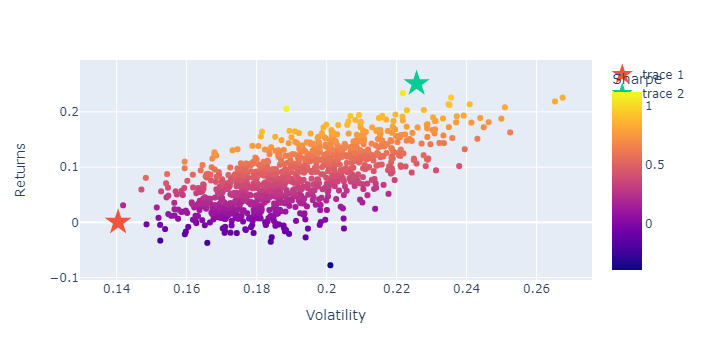

In [106]:
#Plotting Optimal Portfolio & minimum volatitility
plotted = px.scatter(portfolios_v1, x="Volatility", y="Returns", color= "Sharpe")
#Plot the lowest volatility
plotted.add_trace(go.Scatter(mode = 'markers', x=min_vol_value, y=min_vol_return, marker_symbol = 'star', marker_size = 20))
#Plot the Best Sharpe
plotted.add_trace(go.Scatter(mode = 'markers', x=best_sharpe_volatility, y=best_sharpe_returns, marker_symbol = 'star', marker_size = 20))